## Import

In [1]:
%load_ext autoreload
%autoreload 2

from typing import Optional, Union
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
import sys 

sys.path.append('../../modules')
import eumf_data
import eumf_pipeline
import eumf_eval
from eumf_data import Labeled

from sklearn import preprocessing, pipeline, compose, ensemble, model_selection, metrics

pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)



## Load Data

### Migration and Google data

In [2]:
# migration rates
values = eumf_data.load_migration_rates_from_csv()

# google trends
trends = eumf_data.load_trends_from_csv()

countries = eumf_data.get_countries()
keyword_ids = trends.columns.levels[0].tolist()


## Preprocessing

### Imputation

In [3]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
imputed = imputer.fit_transform(values.to_numpy())
values_imputed = pd.DataFrame(imputed, index=values.index, columns=values.columns)


#### Analyze imputation

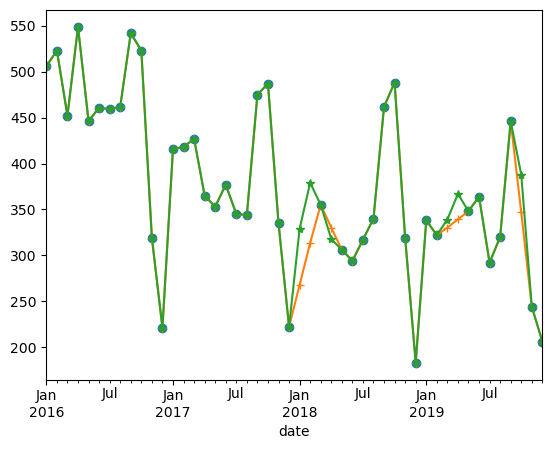

In [4]:
values["value", "SI"]["2016":].plot(marker="o", ls="")
values["value", "SI"]["2016":].interpolate("time").plot(marker="+")
values_imputed["value", "SI"]["2016":].plot(marker="*")
plt.show()


In [5]:
panel = values_imputed.join(trends, how="outer")
panel_3m = panel.resample("3M", closed="left").mean()

panel_3m["2010":"2010"]


value                                                                                                                                                                                                                                                       10                                                                                                                                     ...  59                                                                                                                                60                                                                                                                                                                                 
country        AT       BE        BG       CH       CY      CZ       DK       EE        ES       FI        FR        GB        GR       HR        HU       IE        IT       LT       LU       LV       NL        PL        PT        RO       SE       SI       SK     AT   BE   BG    CH    CY   CZ   DK   EE     ES    FI     FR      GB    GR   HR   HU   IE     IT    LT   LU   LV     NL      PL    PT   ...  CY   CZ   DK   EE     ES    FI     FR      GB    GR   HR   HU   IE    IT    LT   LU   LV    NL    PL   PT   RO   SE   SI   SK     AT      BE      BG      CH    CY     CZ      DK    EE     ES    FI     FR      GB    GR   HR   HU     IE      IT    LT   LU   LV     NL      PL      PT      RO      SE    SI   SK 
date                                                                                                                                                                                                                                                                                                                                                                                                            ...                                                                                                                                                                                                                                                                                                                       
2010-03-31   862.667  216.333  2747.333  368.000  13.667  445.333  180.333   75.667   845.000  144.000  1012.000   692.667   790.000  704.333  1970.667   95.000  1976.000  430.333  148.333  560.667  726.667   7632.000  526.333  4353.000  202.333  144.333  568.667  0.0  0.0  0.0  2.238  0.0  0.0  0.0  0.0  18.429  0.0  19.619  15.762  0.0  0.0  0.0  0.0   8.762  0.0  0.0  0.0  16.667   5.190  0.0  ...  0.0  0.0  0.0  0.0  15.571  0.0  17.048   7.143  0.0  0.0  0.0  0.0  3.714  0.0  0.0  0.0  6.619  0.0  0.0  0.0  0.0  0.0  0.0  18.810   9.095  10.524  21.857  0.0   7.143   5.429  0.0  27.762  0.0  18.381  39.238  0.0  0.0  0.0   3.476   9.857  0.0  0.0  0.0   3.095  11.714  23.238   9.952  17.333  0.0  0.0
2010-06-30   811.667  195.667  3117.667  345.667  10.000  565.667  131.333   81.333   777.667  111.000   916.667   673.000   816.333  910.000  2459.000   98.000  1811.000  515.333  151.667  605.667  742.333  12445.667  511.667  7643.000  163.667  123.667  826.000  0.0  0.0  0.0  7.381  0.0  0.0  0.0  0.0  19.429  0.0   9.286  33.143  0.0  0.0  0.0  0.0   5.619  0.0  0.0  0.0  28.000   9.810  0.0  ...  0.0  0.0  0.0  0.0   8.095  0.0  12.857  29.048  0.0  0.0  0.0  0.0  1.381  0.0  0.0  0.0  2.333  0.0  0.0  0.0  0.0  0.0  0.0  15.238  13.143   0.000  27.286  0.0  11.238   6.571  0.0  27.714  0.0  19.190  50.524  0.0  0.0  0.0  25.143  27.857  0.0  0.0  0.0  31.714  18.095  12.238  10.476  25.143  0.0  0.0
2010-09-30  1168.667  323.000  3891.000  527.333  33.333  618.667  286.000  125.667  1556.333  237.667  1532.333  1209.000  1186.000  944.667  2970.333  173.667  2195.000  617.000  241.000  806.333  925.667  10549.333  645.000  7125.000  290.000  161.000  864.667  0.0  0.0  0.0  6.952  0.0  0.0  0.0  0.0  18.857  0.0  13.905  18.429  0.0  0.0  0.0  0.0   1.714  0.0  0.0  0.0   7.714  11.381  0.0  ...  0.0  0.0  0.0  0.0  23.381  0.0  

Combine countries

In [8]:

panel_comb = eumf_data.combine_countries(panel)


## Analyses

### Investigate distribution of annual change ratios

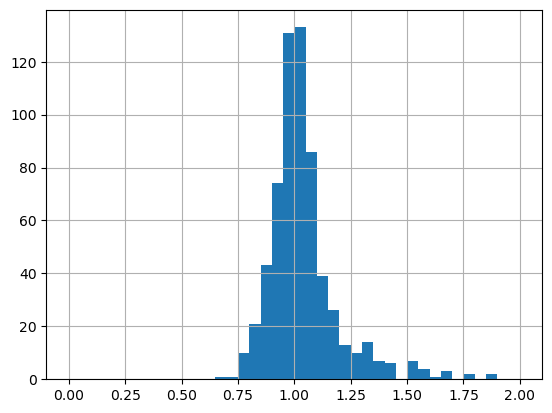

In [15]:
value_resampled = panel_comb["value"].resample("3M").mean()
value_logdiff = value_resampled / value_resampled.shift(4)["2012":"2019"]
value_logdiff.stack().hist(range=[0, 2], bins=40)
plt.show()

# value_logdiff.stack().quantile([0.25,0.5,0.9])


In [16]:
pd.cut(value_logdiff.stack(), [-np.inf, 0.5, 0.90, 1.1, 1.50, np.inf]).value_counts()


(0.9, 1.1]     424
(1.1, 1.5]     115
(0.5, 0.9]      76
(1.5, inf]      25
(-inf, 0.5]      0
dtype: int64

std of "flatline" countries

In [17]:
value_logdiff[["FR", "CH", "GB", "BE+NL+LU"]].std()


country
FR          0.052
CH          0.059
GB          0.068
BE+NL+LU    0.057
dtype: float64

### Analyze volatility across time

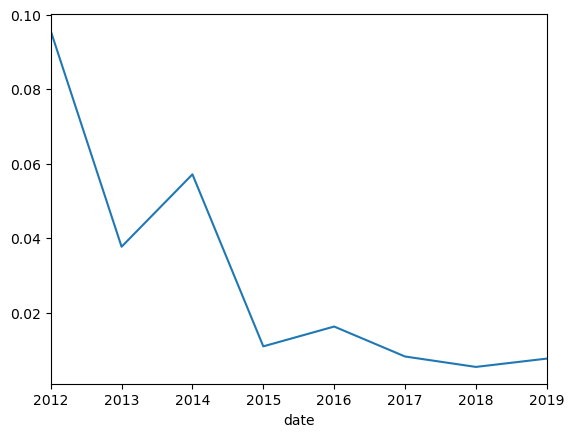

In [28]:
value_logdiff.drop(columns=["AT"]).apply(lambda x : np.log(x)**2).stack().groupby(
    pd.Grouper(level=0, freq="1Y")
).mean().plot()
plt.show()
